In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
import numpy as np
import datetime as dt

import os
import sys
sys.path.append("/project")

from model.hydro.gr4j_prod import ProductionStorage
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate
from data.utils import read_dataset_from_file, get_station_list

In [95]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '318076' #'917107A'
run_dir = '/project/results/hygr4j'

window_size = 5

In [96]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 318076


In [97]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)

In [98]:
X_train = torch.nan_to_num(X_train)
X_val = torch.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [99]:
prod_store = ProductionStorage(x1=817.2529155367329) #953.9338626897935
inp_train = prod_store(X_train, include_x=True)[0]

In [100]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - window_size):
            Xs.append(torch.concat([
                                    X[i: (i + window_size)], 
                                    y[i-1: (i + window_size - 1)]
                                ], dim=1)
                    )
            ys.append(y[i + window_size - 1])

        Xs, ys = torch.stack(Xs), torch.stack(ys)

        return Xs, ys

In [101]:
X_train_seq, y_train_seq = create_sequence(inp_train, y_train, 
                                           window_size=window_size)
X_train_seq.shape, y_train_seq.shape

(torch.Size([8864, 5, 10]), torch.Size([8864, 1]))

In [102]:
inp_val = prod_store(X_val, include_x=True)[0]
X_val_seq, y_val_seq = create_sequence(inp_val, y_val, 
                                       window_size=window_size)
X_val_seq.shape, y_val_seq.shape

(torch.Size([3796, 5, 10]), torch.Size([3796, 1]))

In [103]:
train_ds = torchdata.TensorDataset(X_train_seq, y_train_seq)
train_dl = torchdata.DataLoader(train_ds, batch_size=256, shuffle=False)

val_ds = torchdata.TensorDataset(X_val_seq, y_val_seq)
val_dl = torchdata.DataLoader(val_ds, batch_size=256, shuffle=False)

In [104]:
from model.ml.lstm import LSTM
from model.utils.evaluation import evaluate
from tqdm import tqdm

In [105]:
def val_step(model, dl, loss_fn):
    loss_val = 0.
    model.eval()
    for j, (X, y) in enumerate(dl, start=1):
        y_hat = model(X)
        loss_val += loss_fn(y, y_hat)
    return (loss_val/j).detach()


def train_step(model, dl, loss_fn, opt):
    total_loss = 0.
    model.train()
    for i, (X, y) in enumerate(dl, start=1):
        opt.zero_grad()
        y_hat = model(X)
        loss_val = loss_fn(y, y_hat)
        total_loss += loss_val
        loss_val.backward()
        opt.step()
    return (total_loss/i).detach()

def evaluate_preds(model, ds, batch_size, x_scaler=None, y_scaler=None):
    # Evaluate on train data
    model.eval()
    dl = torchdata.DataLoader(ds, 
                              batch_size=batch_size,
                              shuffle=False)

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    for i, (X, y) in enumerate(dl, start=1):
        
        y_hat = model(X)

        Q.append((y*y_sigma+y_mu).detach().numpy())
        Q_hat.append((y_hat*y_sigma+y_mu).detach().numpy())
        
        X_inv = X[:, -1, :-1]*prod_store.sigma+prod_store.mu
        
        P.append((X_inv[:, 0]).detach().numpy())
        ET.append((X_inv[:, 1]).detach().numpy())
    
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.clip(np.concatenate(Q_hat, axis=0).flatten(), 0, None)


    return evaluate(P, ET, Q, Q_hat)

In [106]:
input_dim = 10
hidden_dim = 32
lstm_dim = 64
n_layers = 2
dropout = 0.2

n_epoch = 400
lr = 1e-3

In [107]:
model = LSTM(input_dim=input_dim,
            hidden_dim=hidden_dim,
            lstm_dim=lstm_dim,
            output_dim=1,
            n_layers=n_layers,
            dropout=dropout)

In [108]:
# Create optimizer and loss instance
opt = torch.optim.Adam(model.parameters(), lr=lr, 
                       betas=(0.89, 0.97), weight_decay=0.02)
loss_fn = nn.MSELoss()

# Early stopping
early_stopper = EarlyStopper(patience=10, min_delta=0.01)

pbar = tqdm(range(1, n_epoch+1))

for epoch in pbar:

    # Train step
    train_loss = train_step(model, train_dl, loss_fn, opt)

    # Validation step
    val_loss = val_step(model, val_dl, loss_fn)
    
    pbar.set_description(f"""Epoch {epoch} loss: {train_loss.numpy():.4f} val_loss: {val_loss.numpy():.4f}""")

    if early_stopper.early_stop(val_loss):
        break

Epoch 76 loss: 0.1534 val_loss: 0.4024:  19%|█▉        | 75/400 [00:37<02:41,  2.01it/s]


(0.8472334891557693, 0.8674783580134091, <Figure size 1600x600 with 1 Axes>)

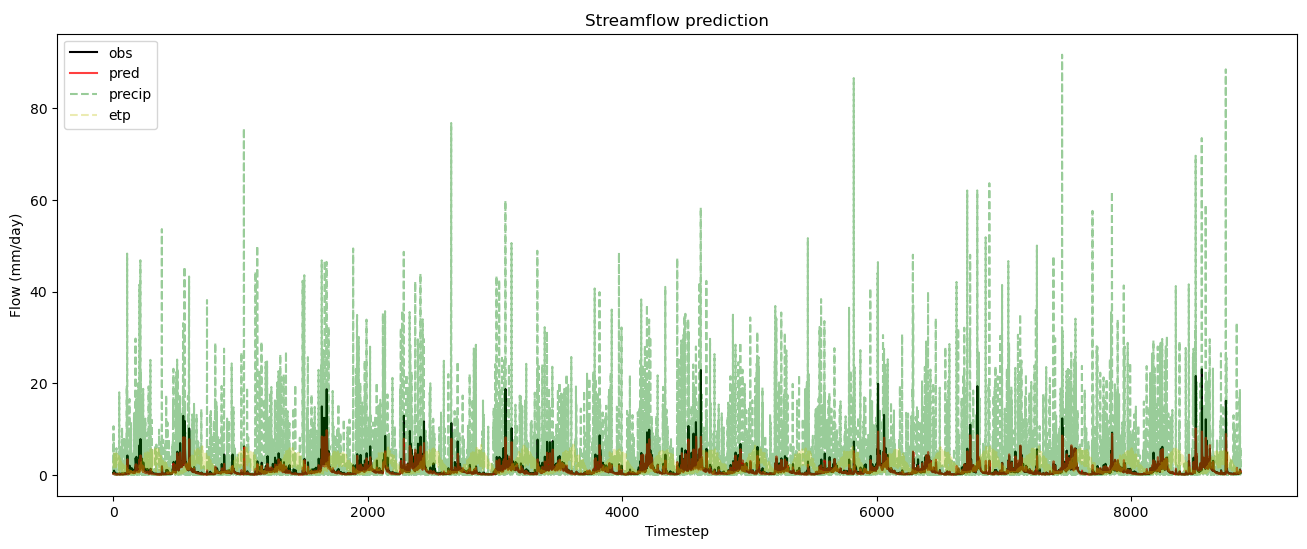

In [109]:
evaluate_preds(model, train_ds, batch_size=256)

(0.7938382178544998, 0.8290761776759473, <Figure size 1600x600 with 1 Axes>)

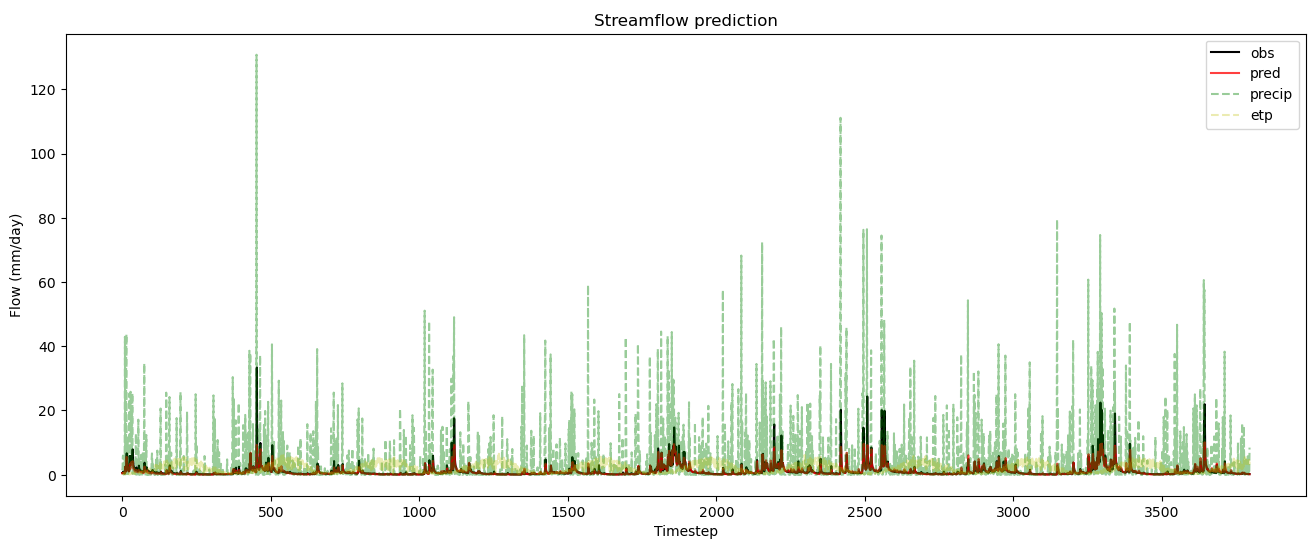

In [110]:
evaluate_preds(model, val_ds, batch_size=256)